## Init

In [122]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

In [123]:
import torch

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

# device = torch.device('cpu')
print(device)

cuda


## SIM score

In [124]:
# %load par3/par3_align/similarity/sim_models.py
import torch
import torch.nn as nn
from torch.nn.modules.distance import CosineSimilarity
import numpy as np

class ParaModel(nn.Module):

    def __init__(self, args, vocab):
        super(ParaModel, self).__init__()

        self.args = args
        self.vocab = vocab
        self.gpu = args.gpu

        self.cosine = CosineSimilarity()

    def compute_mask(self, lengths):

        lengths = lengths.cpu()
        max_len = torch.max(lengths)
        range_row = torch.arange(0, max_len).long()[None, :].expand(lengths.size()[0], max_len)
        mask = lengths[:, None].expand_as(range_row)
        mask = range_row < mask
        mask = mask.float()
        if self.gpu >= 0:
            mask = mask.cuda()
        return mask

    def torchify_batch(self, batch):

        max_len = 0
        for i in batch:
            if len(i.embeddings) > max_len:
                max_len = len(i.embeddings)

        batch_len = len(batch)

        np_sents = np.zeros((batch_len, max_len), dtype='int32')
        np_lens = np.zeros((batch_len,), dtype='int32')

        for i, ex in enumerate(batch):
            np_sents[i, :len(ex.embeddings)] = ex.embeddings
            np_lens[i] = len(ex.embeddings)

        idxs, lengths, masks = torch.from_numpy(np_sents).long(), \
                               torch.from_numpy(np_lens).float().long(), \
                               self.compute_mask(torch.from_numpy(np_lens).long())

        if self.gpu >= 0:
            idxs = idxs.cuda()
            lengths = lengths.cuda()
            masks = masks.cuda()
    
        return idxs, lengths, masks

    def scoring_function(self, g_idxs1, g_mask1, g_lengths1, g_idxs2, g_mask2, g_lengths2):

        g1 = self.encode(g_idxs1, g_mask1, g_lengths1)
        g2 = self.encode(g_idxs2, g_mask2, g_lengths2)
        return self.cosine(g1, g2)

class WordAveraging(ParaModel):

    def __init__(self, args, vocab):
        super(WordAveraging, self).__init__(args, vocab)

        self.vocab = vocab
        self.embedding = nn.Embedding(len(self.vocab), self.args.dim)

        if args.gpu >= 0:
           self.cuda()

    def encode(self, idxs, mask, lengths):
        word_embs = self.embedding(idxs)
        word_embs = word_embs * mask[:, :, None]
        g = word_embs.sum(dim=1) / lengths[:, None].float()
        return g

In [125]:
# %load par3/par3_align/similarity/sim_utils.py
import io
import numpy as np
import torch

def get_wordmap(textfile):
    words={}
    We = []
    f = io.open(textfile, 'r', encoding='utf-8')
    lines = f.readlines()
    if len(lines[0].split()) == 2:
        lines.pop(0)
    ct = 0
    for (n,i) in enumerate(lines):
        word = i.split(' ', 1)[0]
        vec = i.split(' ', 1)[1].split(' ')
        j = 0
        v = []
        while j < len(vec):
            v.append(float(vec[j]))
            j += 1
        words[word] = ct
        ct += 1
        We.append(v)
    return words, np.array(We)

def get_minibatches_idx(n, minibatch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")

    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)

def max_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.max(x[i][0:lengths[i]], 0)[0]
    return out

def mean_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.mean(x[i][0:lengths[i]], 0)
    return out

def lookup(words, w):
    w = w.lower()
    if w in words:
        return words[w]

class Example(object):

    def __init__(self, sentence):
        self.sentence = sentence.strip().lower()
        self.embeddings = []
        self.representation = None

    def populate_embeddings(self, words):
        sentence = self.sentence.lower()
        arr = sentence.split()
        for i in arr:
            emb = lookup(words, i)
            if emb:
                self.embeddings.append(emb)
        if len(self.embeddings) == 0:
            self.embeddings.append(words['UUUNKKK'])

In [126]:
# %load par3/par3_align/similarity/test_sim.py
import torch
from nltk.tokenize import TreebankWordTokenizer
import sentencepiece as spm

tok = TreebankWordTokenizer()

model = torch.load('/home/kkatsy/par3/par3_align/similarity/sim/sim.pt')
state_dict = model['state_dict']
vocab_words = model['vocab_words']
args = model['args']
# turn off gpu
model = WordAveraging(args, vocab_words)
model.load_state_dict(state_dict, strict=True)
sp = spm.SentencePieceProcessor()
sp.Load('/home/kkatsy/par3/par3_align/similarity/sim/sim.sp.30k.model')
model.eval()

def make_example(sentence, model):
    sentence = sentence.lower()
    sentence = " ".join(tok.tokenize(sentence))
    sentence = sp.EncodeAsPieces(sentence)
    wp1 = Example(" ".join(sentence))
    wp1.populate_embeddings(model.vocab)
    return wp1

def find_similarity(s1, s2):
    with torch.no_grad():
        s1 = [make_example(x, model) for x in s1]
        s2 = [make_example(x, model) for x in s2]
        wx1, wl1, wm1 = model.torchify_batch(s1)
        wx2, wl2, wm2 = model.torchify_batch(s2)
        BATCH_SIZE = 512
        all_scores = []
        for i in range(0, len(wx1), BATCH_SIZE):
            scores = model.scoring_function(wx1[i:i + BATCH_SIZE], wm1[i:i + BATCH_SIZE], wl1[i:i + BATCH_SIZE],
                                            wx2[i:i + BATCH_SIZE], wm2[i:i + BATCH_SIZE], wl2[i:i + BATCH_SIZE])
            all_scores.extend([x.item() for x in scores])
        return all_scores

def find_similarity_matrix(s1, s2):
    with torch.no_grad():
        s1 = [make_example(x, model) for x in s1]
        s2 = [make_example(x, model) for x in s2]
        wx1, wl1, wm1 = model.torchify_batch(s1)
        wx2, wl2, wm2 = model.torchify_batch(s2)

        BATCH_SIZE = 2000
        vecs1 = []
        vecs2 = []
        for i in range(0, len(wx1), BATCH_SIZE):
            curr_vecs1 = model.encode(idxs=wx1[i:i + BATCH_SIZE],
                                      mask=wm1[i:i + BATCH_SIZE],
                                      lengths=wl1[i:i + BATCH_SIZE])
            vecs1.append(curr_vecs1)
        for i in range(0, len(wx2), BATCH_SIZE):
            curr_vecs2 = model.encode(idxs=wx2[i:i + BATCH_SIZE],
                                      mask=wm2[i:i + BATCH_SIZE],
                                      lengths=wl2[i:i + BATCH_SIZE])
            vecs2.append(curr_vecs2)
        vecs1 = torch.cat(vecs1)
        vecs2 = torch.cat(vecs2)
        dot_product = torch.matmul(vecs1, vecs2.t())

        vecs1_norm = torch.norm(vecs1, dim=1, keepdim=True)
        vecs2_norm = torch.norm(vecs2, dim=1, keepdim=True)
        norm_product = torch.matmul(vecs1_norm, vecs2_norm.t())
    return torch.div(dot_product, norm_product)

def encode_text(s1):
    with torch.no_grad():
        s1 = [make_example(x, model) for x in s1]
        wx1, wl1, wm1 = model.torchify_batch(s1)
        vecs1 = model.encode(idxs=wx1, mask=wm1, lengths=wl1)
        return vecs1


In [127]:
tok = TreebankWordTokenizer()

model = torch.load('/home/kkatsy/par3/par3_align/similarity/sim/sim.pt')
state_dict = model['state_dict']
vocab_words = model['vocab_words']
args = model['args']
# turn off gpu
model = WordAveraging(args, vocab_words)
model.load_state_dict(state_dict, strict=True)
sp = spm.SentencePieceProcessor()
sp.Load('/home/kkatsy/par3/par3_align/similarity/sim/sim.sp.30k.model')
model.eval()

In [ ]:
def get_score(refs, cands, metric='sim'):
    return find_similarity(refs,cands)

## Data Prep

In [ ]:
import pickle

with open('aligned_paragraph_dataset.pickle', 'rb') as fp:
  aligned_paragraph_dataset = pickle.load(fp)

with open('source_paragraph_dataset.pickle', 'rb') as fp:
  source_paragraph_dataset = pickle.load(fp)

In [ ]:
aligned_paragraph_dataset['NotesFromUnderground'][260:265]

[{'Garnett': '"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."',
  'PV': '"What a scoundrel you are," raced through my head, "to laugh at that now!"',
  'Katz': '"You\'re a scoundrel," the thought flashed through my mind, "if you laugh at that now.\''},
 {'Garnett': '"No matter!" I cried, answering myself. "Now everything is lost!"',
  'PV': '"What of it!" I cried, answering myself. "All is lost now!"',
  'Katz': '"So what!" I cried in reply. "Everything is lost now, anyway!"'},
 {'Garnett': 'There was no trace to be seen of them, but that made no difference—I knew where they had gone.',
  'PV': 'Their trail was already cold; but no matter: I knew where they had gone.',
  'Katz': "There was no sign of them, but it didn't matter. I knew where they were going."},
 {'Garnett': 'At the steps was standing a solitary night sledge-driver in a rough peasant coat, powdered over with the still falling, wet, and as it were warm, snow. It was hot and steamy. Th

In [ ]:
source_paragraph_dataset['NotesFromUnderground'][260:265]

['«Подлец ты!— пронеслось в моей голове,— коли над этим теперь смеешься».',
 '—Пусть!— крикнул я, отвечая себе.— Теперь ведь уж все погибло!',
 'Их уж и след простыл; но все равно: я знал, куда они поехали.',
 'У крыльца стоял одинокий Ванька, ночник, в сермяге, весь запорошенный все еще валившимся мокрым и как будто теплым снегом. Было парно и душно. Маленькая лохматая, пегая лошаденка его была тоже вся запорошена и кашляла; я это очень помню. Я бросился в лубошные санки; но только было я занес ногу, чтоб сесть, воспоминание о том, как Симонов сейчас давал мне шесть рублей, так и подкосило меня, и я, как мешок, повалился в санки.',
 '—Нет! Надо много сделать, чтоб все это выкупить!— прокричал я,— но я выкуплю или в эту же ночь погибну на месте. Пошел!']

In [ ]:
import itertools
from statistics import mean
from operator import itemgetter

def get_best_alignments(par_list, top_k_percent, num_k, drop_top, metric, min_len, max_len):

    # dict -> score:par_set
    # iter thru par_list, prune by length, get metric for set
    keep_index_list = []
    i2score = {}
    for i in range(len(par_list)):
        keep_index_list.append(i)
        par_set = par_list[i]

        max_par_len = len(max(par_set, key = len))
        min_par_len = len(min(par_set, key = len))

        if (min_par_len >= min_len) and (max_par_len) <= max_len and not all(x==par_set[0] for x in par_set):

            pairs = list(itertools.combinations(par_set, 2))
            refs, cands = [], []
            for s1, s2 in pairs:
                refs.append(s1)
                cands.append(s2)
                
            pair_scores = get_score(refs, cands, metric)

            average_score = mean(pair_scores)
            i2score[i] = average_score

    # get top k par sets
    num_pars = len(list(i2score))
    top_k = int(top_k_percent * num_pars)
    if top_k >= num_k:
        top_k_scores = sorted(i2score.items(), key=itemgetter(1), reverse=True)[int(num_pars*drop_top):int(num_pars*drop_top) + num_k]
    else:
        top_k_scores = sorted(i2score.items(), key=itemgetter(1), reverse=True)[int(num_pars*drop_top):int(num_pars*drop_top) + top_k]
    
    i2score = sorted(i2score.items(), key=itemgetter(1), reverse=True)
    return i2score, top_k_scores, keep_index_list

In [ ]:
min_paragraph_len = 40
max_paragraph_len = int(500/2)
top_k_percent = 1
num_k = 50000
drop_top = 0.05

In [ ]:
list(aligned_paragraph_dataset.keys())

['PoorFolk',
 'AnnaKarenina',
 'DeadSouls',
 'TheIdiot',
 'CrimeAndPunishment',
 'NotesFromUnderground',
 'FathersAndSons',
 'TheBrothersKaramazov',
 'Demons']

In [ ]:
# format: label->translator, x->source+translation
# dict: key-> translator, value: list of {source:s, translation:t, index:i}
translator_to_pars = {}
translator_to_pars_holdout = {}

# Holdout
# NotesFromUnderground - Katz, PV, Garnett
# PoorFolk - McDuff, Hogarth, Garnett
holdout_books = ['PoorFolk', 'NotesFromUnderground']

translator_to_pars = {}
translator_to_pars_holdout = {}

# for each book in train:
for book in sorted(list(aligned_paragraph_dataset.keys())):
    # get par list of aligned sentences, best k alignments
    book_par_list = [list(aligned_paragraph_dataset[book][p].values()) for p in range(len(aligned_paragraph_dataset[book]))]

    if book in holdout_books:
        i2score, top_k, keep_idx = get_best_alignments(book_par_list, 1.0, num_k, 0, 'sim', min_paragraph_len, max_paragraph_len)
    else:
        i2score, top_k, keep_idx = get_best_alignments(book_par_list, top_k_percent, num_k, drop_top, 'sim', min_paragraph_len, max_paragraph_len)

    for i, sim in top_k:
        par_trans_dict = aligned_paragraph_dataset[book][i]
        par_source = source_paragraph_dataset[book][i]

        for translator, t in par_trans_dict.items():
            datum_dict = {'source':par_source, 'translation': t, 'idx': i, 'book': book}

            if translator not in translator_to_pars.keys():
                translator_to_pars[translator] = []
                translator_to_pars_holdout[translator] = []
                
            if book in holdout_books:
                translator_to_pars_holdout[translator].append(datum_dict)
                print('len par_list: ', len(book_par_list))
                print('len top_k: ', len(top_k))
            else:
                translator_to_pars[translator].append(datum_dict)

In [ ]:
translator_to_pars['PV'][:5]

[{'source': 'Пришла графиня, села на диван и спросила тоже про жену и про концерт.',
  'translation': 'The countess came in, sat on the sofa and also asked about his wife and the concert.',
  'idx': 6561,
  'book': 'AnnaKarenina'},
 {'source': '«Ведь любит же она моего ребенка, – подумал он, заметив изменение ее лица при крике ребенка, – моего ребенка; как же она может ненавидеть меня»?',
  'translation': '\'But she does love my child, he thought, noticing the change in her face at the child\'s cry, \'my child - so how can she hate me?"',
  'idx': 117,
  'book': 'AnnaKarenina'},
 {'source': 'Лицо Кити вдруг переменилось. Мысли о Тане маркизой, о Долли, все это исчезло.',
  'translation': "Kitty's countenance suddenly changed. Her thoughts about Tanya as a marquise, about Dolly, all vanished.",
  'idx': 4607,
  'book': 'AnnaKarenina'},
 {'source': '– А ты сияешь счастьем и здоровьем! – сказала Долли почти с завистью.',
  'translation': "'And you are radiant with happiness and health,' s

In [ ]:
total = 0
print('Train')
for k in translator_to_pars.keys():
    print(k, len(translator_to_pars[k]))
    total += len(translator_to_pars[k])
print('Total', total)

total = 0
print('\nHoldout')
for k in translator_to_pars_holdout.keys():
    print(k, len(translator_to_pars_holdout[k]))
    total += len(translator_to_pars_holdout[k])
print('Total', total)

Train
PV 12258
Garnett 12319
Katz 3298
McDuff 5277
Hogarth 1789
Total 34941

Holdout
PV 230
Garnett 252
Katz 230
McDuff 22
Hogarth 22
Total 756


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(translator_to_pars.keys()))
print(le.transform(["Garnett", "McDuff", "PV", "Katz", "Hogarth"]))

[0 3 4 2 1]


In [ ]:
data_list = []
i = 0
for tr in translator_to_pars.keys():
    label = le.transform([tr])[0]
    for d in translator_to_pars[tr]:
        src, trn = d['source'], d['translation']
        s = src + ' + ' + trn
        sent_dict = {'idx': d['idx'], 'book':d['book'], 'labels': label, 'sentence': s}
        data_list.append(sent_dict)
        i += 1


data_list_holdout = []
i = 0
for tr in translator_to_pars_holdout.keys():
    label = le.transform([tr])[0]
    for d in translator_to_pars_holdout[tr]:
        src, trn = d['source'], d['translation']
        s = src + ' + ' + trn
        sent_dict = {'idx': d['idx'], 'book':d['book'], 'labels': label, 'sentence': s}
        data_list_holdout.append(sent_dict)
        i += 1
        
print(data_list[:10])

[{'idx': 6561, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': 'Пришла графиня, села на диван и спросила тоже про жену и про концерт. + The countess came in, sat on the sofa and also asked about his wife and the concert.'}, {'idx': 117, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': '«Ведь любит же она моего ребенка, – подумал он, заметив изменение ее лица при крике ребенка, – моего ребенка; как же она может ненавидеть меня»? + \'But she does love my child, he thought, noticing the change in her face at the child\'s cry, \'my child - so how can she hate me?"'}, {'idx': 4607, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': "Лицо Кити вдруг переменилось. Мысли о Тане маркизой, о Долли, все это исчезло. + Kitty's countenance suddenly changed. Her thoughts about Tanya as a marquise, about Dolly, all vanished."}, {'idx': 733, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': "– А ты сияешь счастьем и здоровьем! – сказала Долли почти с завистью. + 'And you are radiant with happiness and h

In [ ]:
import pandas as pd

df = pd.DataFrame(data_list)
df_holdout = pd.DataFrame(data_list_holdout)
pd.set_option('display.max_colwidth', 0)
df.head()

,idx,book,labels,sentence
0,6561,AnnaKarenina,4,"Пришла графиня, села на диван и спросила тоже про жену и про концерт. + The countess came in, sat on the sofa and also asked about his wife and the concert."
1,117,AnnaKarenina,4,"«Ведь любит же она моего ребенка, – подумал он, заметив изменение ее лица при крике ребенка, – моего ребенка; как же она может ненавидеть меня»? + 'But she does love my child, he thought, noticing the change in her face at the child's cry, 'my child - so how can she hate me?"""
2,4607,AnnaKarenina,4,"Лицо Кити вдруг переменилось. Мысли о Тане маркизой, о Долли, все это исчезло. + Kitty's countenance suddenly changed. Her thoughts about Tanya as a marquise, about Dolly, all vanished."
3,733,AnnaKarenina,4,"– А ты сияешь счастьем и здоровьем! – сказала Долли почти с завистью. + 'And you are radiant with happiness and health,' said Dolly, almost with envy."
4,1730,AnnaKarenina,4,"Левин, ставивший между тем ружье в шкаф, уже выходил из двери, но, услыхав слова купца, остановился. + Levin, who meanwhile had put his gun away in a cupboard, was going out of the door, but hearing the merchant's words, he stopped."


In [ ]:
df.shape
# df_holdout.shape

(34941, 4)

In [ ]:
from sklearn.model_selection import train_test_split

# train_texts = df['sentence'].values.tolist()
# train_labels = df['labels'].values.tolist()
test_texts = df_holdout['sentence'].values.tolist()
test_labels = df_holdout['labels'].values.tolist()

train_texts =  df['sentence'].values.tolist()
train_labels = df['labels'].values.tolist()
# train_texts, _, train_labels, _ = train_test_split(
#     df['sentence'].values.tolist(), df['labels'].values.tolist(),
#     stratify = df['labels'], test_size=0.55, shuffle=True
# )

print('train size: ', len(list(train_labels)))
print('test size: ', len(list(test_labels)))

sentences = {}
sentences['train'] = []
sentences['test'] = []
for t, l in zip(train_texts, train_labels):
    datum = {'label': l, 'text': t}
    sentences['train'].append(datum)
for t, l in zip(test_texts, test_labels):
    datum = {'label': l, 'text': t}
    sentences['test'].append(datum)

print(sentences['train'][4])

train size:  34941
test size:  756
{'label': 4, 'text': "Левин, ставивший между тем ружье в шкаф, уже выходил из двери, но, услыхав слова купца, остановился. + Levin, who meanwhile had put his gun away in a cupboard, was going out of the door, but hearing the merchant's words, he stopped."}


## Train Model

In [ ]:
if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

In [ ]:
BERT_MODEL = "bert-base-multilingual-cased"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
import datasets
import pandas as pd

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['train']))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['test']))

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/34941 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
label_list = translator_to_pars.keys()
id_list = le.transform(list(label_list))

id2label = {}
label2id = {}
for l, i in zip(label_list, id_list):
    id2label[i] = l
    label2id[l] = i

print(id2label)
print(label2id)

{4: 'PV', 0: 'Garnett', 2: 'Katz', 3: 'McDuff', 1: 'Hogarth'}
{'PV': 4, 'Garnett': 0, 'Katz': 2, 'McDuff': 3, 'Hogarth': 1}


In [ ]:
fine_tune = True

In [ ]:
from numpy import mean
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# device (turn on GPU acceleration for faster execution)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if fine_tune:
    # model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = len(translator_to_pars.keys()))
    model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 2e-5
epochs = 20
batch_size = 16

In [ ]:
import wandb

run = wandb.init(
        # Set the project where this run will be logged
        project="translator-classification-aligned",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": epochs,
        },
    )

os.environ["WANDB_PROJECT"]="translator-classification-aligned"
os.environ["WANDB_NOTEBOOK_NAME"]="translator-classification-aligned"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kkatsy. Use `wandb login --relogin` to force relogin


In [ ]:
if fine_tune:
    training_args = TrainingArguments(
        output_dir="/trunk/kkatsy/aligned_20epochs_holdout",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="wandb"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
if fine_tune:
    trainer.train()

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.675700,1.155797,0.510582
2,0.537500,1.208959,0.541005
3,0.416800,1.342963,0.584656
4,0.317300,1.325534,0.575397
5,0.253300,1.745755,0.574074
6,0.184000,1.943714,0.582011
7,0.159100,2.409930,0.579365
8,0.120300,2.975598,0.576720
9,0.083500,3.178887,0.582011
10,0.055100,3.377826,0.592593


/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, bu

In [ ]:
if fine_tune:
    trainer.evaluate()

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▄▇▇▆▇▇▇▇█▁
eval/loss,▁▁▂▂▃▃▅▇▇█▁
eval/runtime,▁▁▁▁▁▁▁▇▇█▇
eval/samples_per_second,███████▁▂▁▂
eval/steps_per_second,███████▂▂▁▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▆▅▅▅▄▄▄▃▃▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


## Load Model

In [ ]:
# import gc
# del model
# gc.collect()

# torch.cuda.empty_cache()

In [ ]:
load_tuned = False

In [ ]:
if load_tuned:
    model = AutoModelForSequenceClassification.from_pretrained("/trunk/kkatsy/aligned_20epochs_holdout/checkpoint-21840")
    model.to(device)

In [ ]:
if load_tuned:
    training_args = TrainingArguments(
        output_dir="/trunk/kkatsy/aligned_20epochs_holdout",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="wandb"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Evaluate

In [ ]:
# if load_tuned:
#     trainer.evaluate()

In [ ]:
predictions, labels, metrics = trainer.predict(tokenized_test, metric_key_prefix="predict")

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
preds = np.argmax(predictions, axis=-1)

In [ ]:
translators = [id2label[l] for l in preds]

pred_count = {}
for i in label2id.keys():
    count = translators.count(i)
    pred_count[i] = count

pred_count

{'PV': 313, 'Garnett': 296, 'Katz': 120, 'McDuff': 19, 'Hogarth': 8}

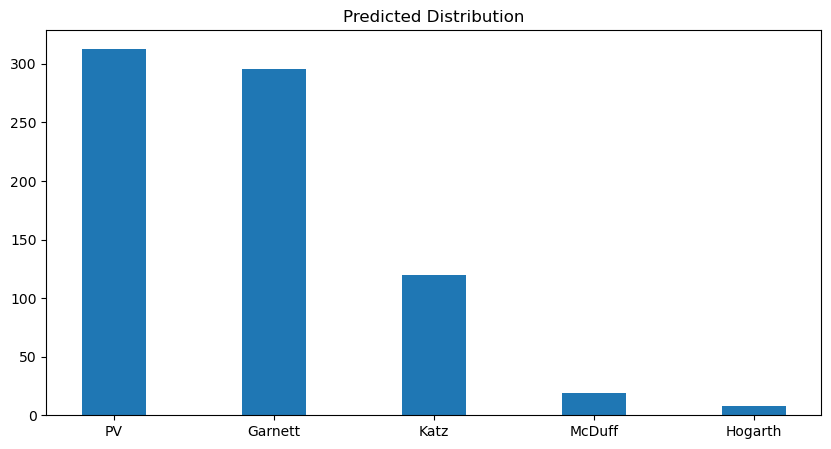

In [ ]:
import matplotlib.pyplot as plt


courses = list(pred_count.keys())
values = list(pred_count.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Predicted Distribution")
plt.show()

In [ ]:
true_count = {}
for i in id2label.keys():
    count = test_labels.count(i)
    true_count[id2label[i]] = count

true_count

{'PV': 230, 'Garnett': 252, 'Katz': 230, 'McDuff': 22, 'Hogarth': 22}

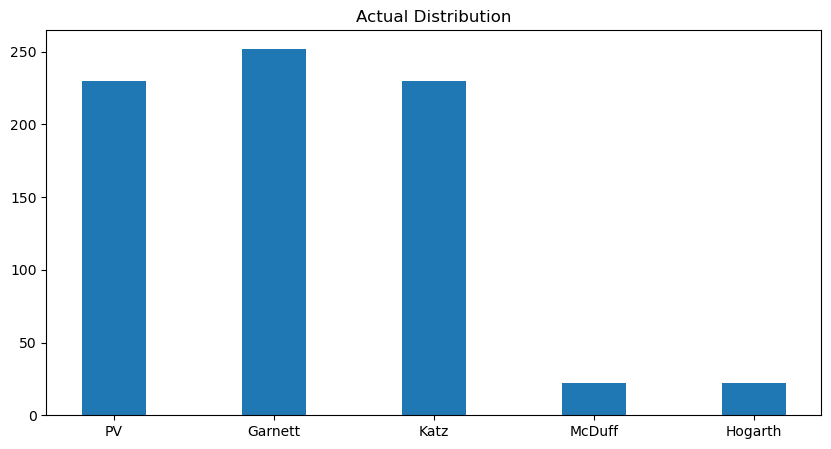

In [ ]:
courses = list(true_count.keys())
values = list(true_count.values())
  
fig2 = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Actual Distribution")
plt.show()

Accuracy:  0.5925925925925926


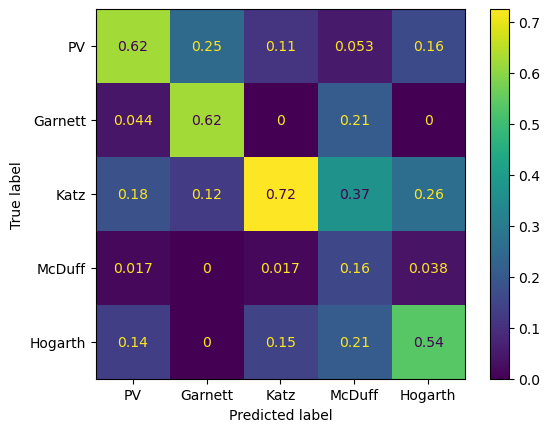

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

acc = metrics.accuracy_score(labels, preds)
print('Accuracy: ', acc)

confusion_matrix = metrics.confusion_matrix(labels, preds, normalize='pred')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=label2id)
cm_display.plot()
plt.show()

In [ ]:
# idiom lookup: search russian and english datasets for idioms
# english idiom dataset